In [5]:
#admm using jeremykarnowski blog

import sys
import time
from numpy import *
from numpy.linalg import svd, norm
from multiprocessing.pool import ThreadPool

def prox_l1(v,lambdat):
    """
    The proximal operator of the l1 norm.
    prox_l1(v,lambdat) is the proximal operator of the l1 norm
    with parameter lambdat.
    Adapted from: https://github.com/cvxgrp/proximal/blob/master/matlab/prox_l1.m
    """

    return maximum(0, v - lambdat) - maximum(0, -v - lambdat)


def prox_matrix(v,lambdat,prox_f):
    """
    The proximal operator of a matrix function.
    Suppose F is a orthogonally invariant matrix function such that
    F(X) = f(s(X)), where s is the singular value map and f is some
    absolutely symmetric function. Then
    X = prox_matrix(V,lambdat,prox_f)
    evaluates the proximal operator of F via the proximal operator
    of f. Here, it must be possible to evaluate prox_f as prox_f(v,lambdat).
    For example,
    prox_matrix(V,lambdat,prox_l1)
    evaluates the proximal operator of the nuclear norm at V
    (i.e., the singular value thresholding operator).
    Adapted from: https://github.com/cvxgrp/proximal/blob/master/matlab/prox_matrix.m
    """

    U,S,V = svd(v,full_matrices=False)
    S = S.reshape((len(S),1))
    pf = diagflat(prox_f(S,lambdat))
    # It should be V.conj().T given MATLAB-Python conversion, but matrix
    # matches with out the .T so kept it.
    return U.dot(pf).dot(V.conj())


def avg(*args):
    N = len(args)
    x = 0
    for k in range(N):
        x = x + args[k]
    x = x/N
    return x


def objective(X_1, g_2, X_2, g_3, X_3):
    """
    Objective function for Robust PCA:
        Noise - squared frobenius norm (makes X_i small)
        Background - nuclear norm (makes X_i low rank)
        Foreground - entrywise L1 norm (makes X_i small)
    """
    tmp = svd(X_3,compute_uv=0)
    tmp = tmp.reshape((len(tmp),1))
    return norm(X_1,'fro')**2 + g_2*norm(hstack(X_2),1) + g_3*norm(tmp,1)


def rpcaADMM(data):
    """
    ADMM implementation of matrix decomposition. In this case, RPCA.
    Adapted from: http://web.stanford.edu/~boyd/papers/prox_algs/matrix_decomp.html
    """

    pool = ThreadPool(processes=3) # Create thread pool for asynchronous processing

    N = 3         # the number of matrices to split into 
                  # (and cost function expresses how you want them)
 
    A = float_(data)    # A = S + L + V
    m,n = A.shape

    g2_max = norm(hstack(A).T,inf)
    g3_max = norm(A,2)
    g2 = 0.15*g2_max
    g3 = 0.15*g3_max

    MAX_ITER = 100
    ABSTOL   = 1e-4
    RELTOL   = 1e-2

    start = time.time()

    lambdap = 1.0
    rho = 1.0/lambdap

    X_1 = zeros((m,n))
    X_2 = zeros((m,n))
    X_3 = zeros((m,n))
    z   = zeros((m,N*n))
    U   = zeros((m,n))

    print ('\n%3s\t%10s\t%10s\t%10s\t%10s\t%10s' %('iter',
                                                  'r norm', 
                                                  'eps pri', 
                                                  's norm', 
                                                  'eps dual', 
                                                  'objective'))

    # Saving state
    h = {}
    h['objval'] = zeros(MAX_ITER)
    h['r_norm'] = zeros(MAX_ITER)
    h['s_norm'] = zeros(MAX_ITER)
    h['eps_pri'] = zeros(MAX_ITER)
    h['eps_dual'] = zeros(MAX_ITER)

    def x1update(x,b,l):
        return (1.0/(1.0+l))*(x - b)
    def x2update(x,b,l,g,pl):
        return pl(x - b, l*g)
    def x3update(x,b,l,g,pl,pm):
        return pm(x - b, l*g, pl)

    def update(func,item):
        return map(func,[item])[0]

    for k in range(MAX_ITER):

        B = avg(X_1, X_2, X_3) - A/N + U

        # Original MATLAB x-update
        # X_1 = (1.0/(1.0+lambdap))*(X_1 - B)
        # X_2 = prox_l1(X_2 - B, lambdap*g2)
        # X_3 = prox_matrix(X_3 - B, lambdap*g3, prox_l1)

        # Parallel x-update
        async_X1 = pool.apply_async(update, (lambda x: x1update(x,B,lambdap), X_1))
        async_X2 = pool.apply_async(update, (lambda x: x2update(x,B,lambdap,g2,prox_l1), X_2))
        async_X3 = pool.apply_async(update, (lambda x: x3update(x,B,lambdap,g3,prox_l1,prox_matrix), X_3))

        X_1 = async_X1.get()
        X_2 = async_X2.get()
        X_3 = async_X3.get()

        # (for termination checks only)
        x = hstack([X_1,X_2,X_3])
        zold = z
        z = x + tile(-avg(X_1, X_2, X_3) + A*1.0/N, (1, N))

        # u-update
        U = B

        # diagnostics, reporting, termination checks
        h['objval'][k]   = objective(X_1, g2, X_2, g3, X_3)
        h['r_norm'][k]   = norm(x - z,'fro')
        h['s_norm'][k]   = norm(-rho*(z - zold),'fro');
        h['eps_pri'][k]  = sqrt(m*n*N)*ABSTOL + RELTOL*maximum(norm(x,'fro'), norm(-z,'fro'));
        h['eps_dual'][k] = sqrt(m*n*N)*ABSTOL + RELTOL*sqrt(N)*norm(rho*U,'fro');

        if (k == 0) or (mod(k+1,10) == 0):
            print('%4d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f' %(k+1,
                                                                  h['r_norm'][k], 
                                                                  h['eps_pri'][k], 
                                                                  h['s_norm'][k], 
                                                                  h['eps_dual'][k], 
                                                                  h['objval'][k]))
        if (h['r_norm'][k] < h['eps_pri'][k]) and (h['s_norm'][k] < h['eps_dual'][k]):
            break

    h['addm_toc'] = time.time() - start
    h['admm_iter'] = k
    h['X1_admm'] = X_1
    h['X2_admm'] = X_2
    h['X3_admm'] = X_3

    return h

In [8]:
import numpy as np
data = np.array([[1,2,3],[44,55,28],[92,67,11]])
print(rpcaADMM(data))


iter	    r norm	   eps pri	    s norm	  eps dual	 objective


TypeError: 'map' object is not subscriptable

#dganguli/rb_pca github


In [1]:
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.frobenius_norm(self.D))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

iteration: 1, error: 5.092055139689222
iteration: 100, error: 0.09063810752329611
iteration: 200, error: 0.05293771170726005
iteration: 300, error: 0.016052132617550983
iteration: 400, error: 0.02045990305944749
iteration: 500, error: 0.019869815341461115
iteration: 600, error: 0.02703274520931606
iteration: 700, error: 0.07088593550504217
iteration: 800, error: 0.035949725891751806
iteration: 900, error: 0.010496140635849563
iteration: 1000, error: 0.07454601694960775
iteration: 1061, error: 0.00020452363831349656
ymin: 0.0, ymax: 30.0


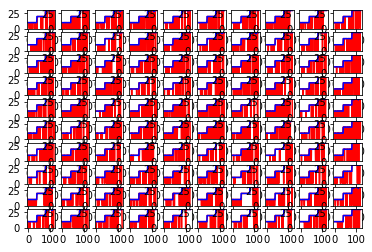

In [17]:
# generate low rank synthetic data
N = 100
num_groups = 3
num_values_per_group = 40
p_missing = 0.2

Ds = []
for k in range(num_groups):
    d = np.ones((N, num_values_per_group)) * (k + 1) * 10
    Ds.append(d)

D = np.hstack(Ds)

# decimate 20% of data 
n1, n2 = D.shape
S = np.random.rand(n1, n2)
D[S < 0.2] = 0

# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)

# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()

In [29]:
import numpy as np
import os
import cv2

frame = cv2.imread(r'C:\Users\Legion\Desktop\Internship_IIT\UCSD_Anomaly_Dataset.v1p2\UCSDped2\Test\Test001\140.tif',0)
rpca = R_pca(frame)
L, S = rpca.fit(max_iter=10000, iter_print=100)

cv2.imshow('l',np.absolute(L))
cv2.imshow('S',np.absolute(S))
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


print(L)
print(S)

iteration: 1, error: 16.80527528752276
iteration: 100, error: 0.25514497394055063
iteration: 200, error: 0.1317203070720057
iteration: 300, error: 0.09885014944479614
iteration: 400, error: 0.05742853785689306
iteration: 500, error: 0.04297492790358869
iteration: 600, error: 0.034416870972455625
iteration: 700, error: 0.02497299706509014
iteration: 800, error: 0.01989475887222223
iteration: 900, error: 0.016406750753400607
iteration: 1000, error: 0.011850744088726457
iteration: 1100, error: 0.009258889742223143
iteration: 1200, error: 0.008567204000947869
iteration: 1300, error: 0.006581584402859878
iteration: 1400, error: 0.005287408401206959
iteration: 1500, error: 0.004745743194055943
iteration: 1584, error: 0.0035912699888806946
[[  49.70618888   48.99997997   47.04824047 ...,  100.00003046
    99.99999033   99.99999565]
 [  49.71010582   49.00001539   46.99997496 ...,   96.99997436   96.9483898
    97.00000471]
 [  50.00000222   49.4723702    47.00000834 ...,   93.7740166    92.45

In [39]:
s = np.absolute(S).copy()
indices = S < 9.00
s[indices] = 0

cv2.imshow('s',s)
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
indices = S>




cv2.imshow('l',np.absolute(L))
cv2.imshow('S',np.absolute(S))
cv2.imshow('frame',frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [28]:
f1 = np.load('final_task_feature_matrix_1.dat')
f2 = np.load('final_task_feature_matrix_2.dat')


rpca1 = R_pca(f1)
L1, S1 = rpca1.fit(max_iter=10000, iter_print=100)
print(np.sum(f1==(L1+S1)))

print("\n\n\n\n\n")

rpca2 = R_pca(f2)
L2, S2 = rpca2.fit(max_iter=10000, iter_print=100)
print(np.sum(f2==(L2+S2)))

iteration: 1, error: 0.7896335299790105
iteration: 100, error: 0.013430045754467263
iteration: 200, error: 0.008519549610054574
iteration: 300, error: 0.005646591142828168
iteration: 400, error: 0.003963963289842609
iteration: 500, error: 0.0027722916313526087
iteration: 600, error: 0.0022955681839823814
iteration: 700, error: 0.0017328231651654686
iteration: 800, error: 0.0012580040291435338
iteration: 900, error: 0.0011189538687453617
iteration: 1000, error: 0.000919401763865049
iteration: 1100, error: 0.0009065805726918898
iteration: 1200, error: 0.0006796723647952125
iteration: 1300, error: 0.0006158926123766906
iteration: 1400, error: 0.000546157548803969
iteration: 1500, error: 0.0005644864583691321
iteration: 1600, error: 0.0003923578506568539
iteration: 1700, error: 0.0003751084917489571
iteration: 1800, error: 0.00030747834738549475
iteration: 1900, error: 0.00028180093495933984
iteration: 2000, error: 0.00026217176305681636
iteration: 2100, error: 0.00020742430632271806
itera

In [38]:
S = S2

In [44]:
import os
import cv2
#displaying the frames
#taking the threshold as 2.000
threshold = 0.20
M_step = 20
N_step = 20

frameset_path = r'C:\Users\Legion\Desktop\Internship_IIT\UCSD_Anomaly_Dataset.v1p2\UCSDped2\Test\Test001'
list_frames_name = os.listdir(frameset_path)

if '._.DS_Store' in list_frames_name:
    list_frames_name.remove('._.DS_Store')
    
if '.DS_Store' in list_frames_name:
    list_frames_name.remove('.DS_Store')


ref_frame = cv2.imread(os.path.join(frameset_path,list_frames_name[0]),0)
print(ref_frame)
cv2.imshow('frame', ref_frame)

num_blocks_y= ref_frame.shape[1]//N_step


for idx,frame_name in enumerate(list_frames_name[1:]):
    frame_path = os.path.join(frameset_path,frame_name)
    frame = cv2.imread(frame_path, 0)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
    sparse_column = S[:, idx]
    
    for i,val in enumerate(sparse_column):
        if(val>threshold):
            lower_x = int(i//num_blocks_y)*20
            lower_y = int(i%num_blocks_y)*20
            upper_x = int(lower_x + M_step)
            upper_y = int(lower_y + N_step)
            print(i,idx, 'mapped to' ,lower_x,lower_y)
            #print('lower:',type(lower_x), type(lower_y),'\n',end=' ')
            #print('upper:',type(lower_x +M_step) ,type(lower_y + N_step),'\n',end=' ')
            
            cv2.rectangle(frame, (lower_x, lower_y), (upper_x, upper_y), (0,255,255), 1)
            
    cv2.imshow('frame', frame)
    k = cv2.waitKey(0) & 0xff
    if k == ord('q'):
        break
        
        
cv2.destroyAllWindows()
    
    


[[ 48  48  48 ..., 101  99  97]
 [ 48  48  48 ...,  97  94  92]
 [ 48  48  48 ...,  91  89  87]
 ..., 
 [ 76  76  76 ...,  74  71  67]
 [ 76  76  76 ...,  67  68  73]
 [ 76  76  76 ...,  55  61  73]]
23 5 mapped to 20 100
41 5 mapped to 40 100
29 6 mapped to 20 220
26 9 mapped to 20 160
28 15 mapped to 20 200
59 15 mapped to 60 100
174 18 mapped to 180 240
83 22 mapped to 80 220
33 28 mapped to 20 300
52 32 mapped to 40 320
183 36 mapped to 200 60
63 56 mapped to 60 180
35 61 mapped to 20 340
41 62 mapped to 40 100
29 63 mapped to 20 220
56 64 mapped to 60 40
72 64 mapped to 80 0
72 65 mapped to 80 0
25 71 mapped to 20 140
44 74 mapped to 40 160
67 74 mapped to 60 260
189 74 mapped to 200 180
29 77 mapped to 20 220
129 81 mapped to 140 60
143 85 mapped to 140 340
170 85 mapped to 180 160
143 86 mapped to 140 340
142 89 mapped to 140 320
167 92 mapped to 180 100
167 93 mapped to 180 100
100 94 mapped to 100 200
210 96 mapped to 220 240
193 97 mapped to 200 260
153 98 mapped to 160 180
1